In [68]:

import sys
sys.path.append('../')

import numpy as np  # Linear algebra
from typing import Optional, Union, Callable, Tuple  # Type hints
import e3nn_jax as e3nn  # E(3)-equivariant neural networks
import jax  # Accelerated numerical computing and automatic differentiation
import optax  # Gradient-based optimization
import matplotlib.animation as animation
import jax.numpy as jnp  # Compatibility with JAX functions
import matplotlib.pyplot as plt  # Data visualization
from matplotlib.lines import Line2D  # Custom line styles
import plotly  # Interactive data visualization
import plotly.graph_objects as go  # Interactive plots
import pandas as pd  # Data manipulation and analysis
from tqdm import tqdm  # Progress bars and iteration monitoring
from sklearn.cluster import KMeans

plt.rcParams["animation.html"] = "jshtml"

In [55]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
%autoreload 2
from src import spectra

In [57]:
def visualize(geometry):
    sig = spectra.with_peaks_at(geometry, lmax=4)

    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(255,255,255,255)', range=[-2.5, 2.5]),
            yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(255,255,255,255)', range=[-2.5, 2.5]),
            zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(255,255,255,255)', range=[-2.5, 2.5]),
            bgcolor='rgba(255,255,255,255)',
            aspectmode='cube',
            camera=dict(
                eye=dict(x=0.5, y=0.5, z=0.5)
            )
        ),
        plot_bgcolor='rgba(255,255,255,255)',
        paper_bgcolor='rgba(255,255,255,255)',
        margin=dict(l=0, r=0, t=0, b=0),
        legend=dict(
            yanchor="top",
            y=1,
            xanchor="left",
            x=0
        )
    )

    spherical_harmonics_trace = go.Surface(e3nn.to_s2grid(sig, 100, 99, quadrature="soft").plotly_surface(radius=1., normalize_radius_by_max_amplitude=True, scale_radius_by_amplitude=True), name="Signal", showlegend=True)
    atoms_trace = go.Scatter3d(x=geometry[:, 0], y=geometry[:, 1], z=geometry[:, 2], mode='markers', marker=dict(size=10, color='black'), showlegend=True, name="Points")
    fig = go.Figure()
    fig.add_trace(spherical_harmonics_trace)
    fig.add_trace(atoms_trace)
    fig.update_layout(layout)
    return fig

def colorplot(arr: jnp.ndarray):
    """Helper to plot a 1D array as a color plot."""
    plt.figure(figsize=(15, 1))
    plt.axis("off")
    vmax = jnp.maximum(jnp.abs(jnp.min(arr)), jnp.max(arr))
    return plt.imshow(arr[None, :], cmap="RdBu", vmin=-vmax, vmax=vmax)

In [58]:
true_geometry = jnp.asarray([
    [1, 0, 0],
    [-0.5, np.sqrt(3)/2, 0],
    [-0.5, -np.sqrt(3)/2, 0]
])
true_geometry = true_geometry / np.linalg.norm(true_geometry, axis=-1, keepdims=True)

true_sig = spectra.with_peaks_at(true_geometry, lmax=4)

bispectrum = spectra.Spectra(lmax=4, order=2)
true_spectrum = bispectrum.compute_geometry(true_geometry)

all_steps, all_params, all_losses, all_grad_norms = bispectrum.invert(true_spectrum, n_points=3)

Step 0, Loss: 4.7047521434251394e-08
Step 100, Loss: 4.241357132173107e-08
Step 200, Loss: 4.241351447831221e-08
Step 300, Loss: 4.241351803102589e-08
Step 400, Loss: 4.2413521583739566e-08
Step 500, Loss: 4.2413521583739566e-08
Step 600, Loss: 4.2413521583739566e-08
Step 700, Loss: 4.2413521583739566e-08
Step 800, Loss: 4.2413521583739566e-08
Step 900, Loss: 4.2413521583739566e-08


In [59]:
# Create a figure and a 3D Axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Predicted Geometry as a Function of Training Iteration')

# Create a scatter plot
points = np.stack([all_params[index]['predicted_geometry'] for index in range(len(all_params))])

# Colour points using distance from final geometry
kmeans = KMeans(n_clusters=true_geometry.shape[0], n_init='auto')  # Change the number of clusters as needed
kmeans.fit(points[-1])


# Update function for the animation
def update(i):
    ax.clear()

    # Get the cluster assignments for each point
    labels = kmeans.predict(points[i, :])

    # Colour the points by their assigned cluster
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2], s=100, c=labels, cmap='tab10')

    # Formatting.
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_zlim(-1.5, 1.5)
    ax.grid(False)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(all_params), interval=200)
plt.close()
ani

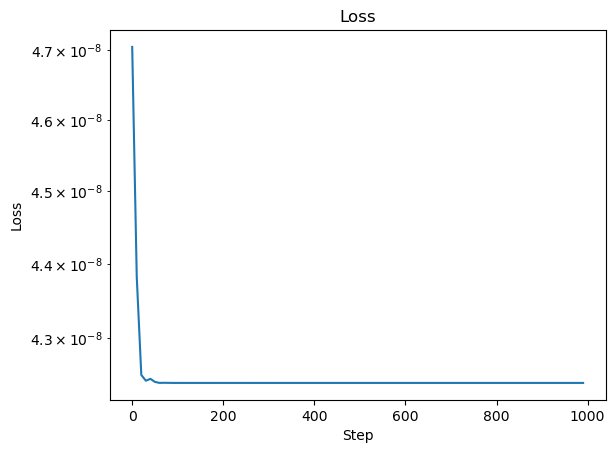

In [60]:
plt.plot(all_steps, all_losses)
plt.title("Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

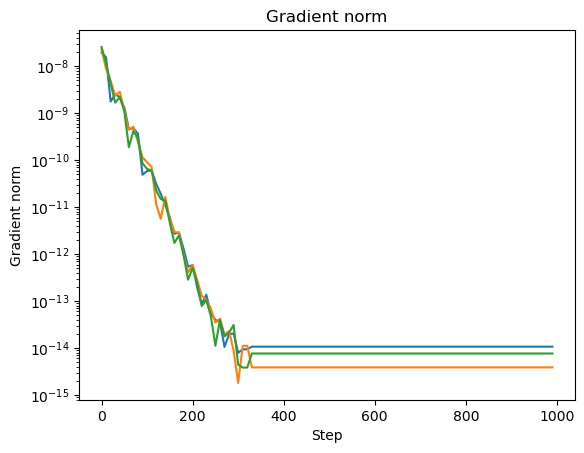

In [61]:
plt.plot(all_steps, all_grad_norms)
plt.xlabel("Step")
plt.title("Gradient norm")
plt.ylabel("Gradient norm")
plt.yscale("log")
plt.show()

In [62]:
predicted_geometry = all_params[-1]["predicted_geometry"]

In [63]:
visualize(true_geometry)

In [64]:
visualize(predicted_geometry)

In [66]:
optax.l2_loss(true_spectrum, bispectrum.compute_geometry(predicted_geometry)).mean()

Array(4.2413525e-08, dtype=float32)

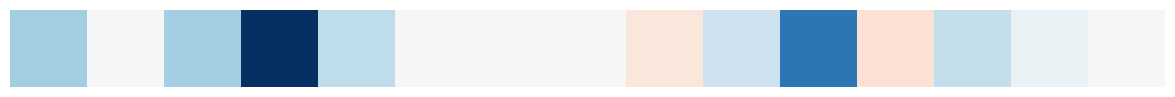

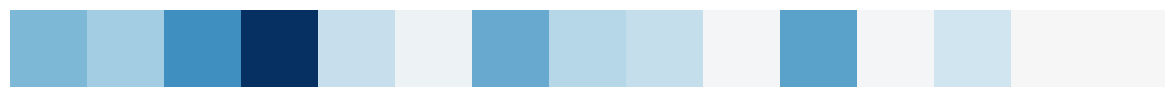

In [67]:
colorplot(true_spectrum);
colorplot(bispectrum.compute_geometry(predicted_geometry));

In [70]:
fig = visualize(true_geometry)
type(fig)

plotly.graph_objs._figure.Figure